## 檢查 GPU

In [1]:
!nvidia-smi

Fri Sep 11 00:14:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 下載資料集

In [2]:
! cp "/content/drive/My Drive/aidataset/aoi.zip" ./

In [3]:
! unzip aoi.zip > aoi.log

In [34]:
! unzip train_images.zip > train_images.log

## 檢視資料集

In [5]:
! head train.csv

ID,Label
train_00000.png,0
train_00001.png,1
train_00002.png,1
train_00003.png,5
train_00004.png,5
train_00005.png,5
train_00006.png,3
train_00007.png,0
train_00008.png,3


In [6]:
import pandas as pd
train_df = pd.read_csv('train.csv')
train_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


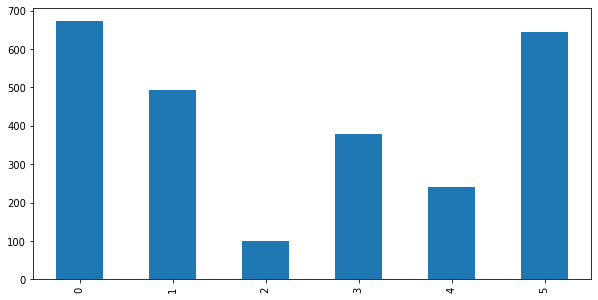

In [7]:
train_df['Label'].value_counts().sort_index().plot(kind = 'bar', figsize = [10,5])

In [8]:
len(train_df)

2528

In [9]:
! head test.csv

ID,Label
test_00000.png,
test_00001.png,
test_00002.png,
test_00003.png,
test_00004.png,
test_00005.png,
test_00006.png,
test_00007.png,
test_00008.png,


## 檢視影像

In [10]:
import matplotlib.image as mpimg
img0 = mpimg.imread('train_images/train_00000.png')
img1 = mpimg.imread('train_images/train_00001.png')
img2 = mpimg.imread('train_images/train_00118.png')
img3 = mpimg.imread('train_images/train_00006.png')
img4 = mpimg.imread('train_images/train_00028.png')
img5 = mpimg.imread('train_images/train_00003.png')
images = [img0,img1,img2,img3,img4,img5]

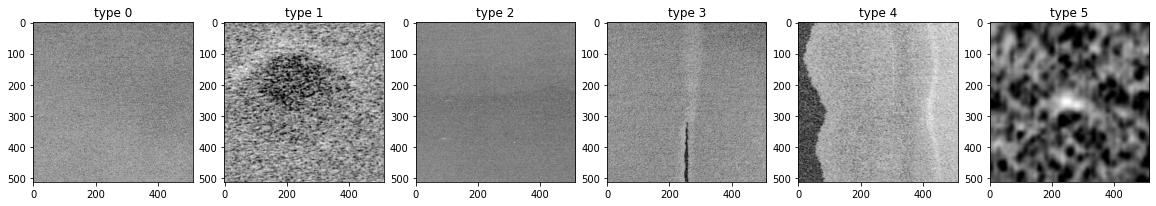

In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,5))
for idx, img in enumerate(images):
  plt.subplot(1,6,idx+1)
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title('type {}'.format(idx))
plt.show()

## 建立訓練與測試資料集

In [35]:
trainCSV=pd.read_csv("train.csv")

train_path = 'train_images/train/'
valid_path = 'train_images/valid/'
test_path = 'train_images/test/'

test_path2 = 'test_images/'

In [36]:
from glob import glob
all_training_files = glob("train_images/*.png")
print(len(all_training_files))

2528


In [37]:
import os
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

In [38]:
import numpy as np
import ntpath, os

shuffles = np.random.permutation(all_training_files)

if len(all_training_files) > 0:
    testInd = int(np.floor(len(all_training_files)*0.85))
    validInd = int(np.floor(len(all_training_files)*0.7))
    for i in range(0, validInd):
        file=ntpath.basename(shuffles[i])
        label=trainCSV.loc[trainCSV['ID'] == file, 'Label'].iloc[0]
        newpath=shuffles[i].replace('train_images', train_path+str(label))
        newdir = '/'.join(newpath.split('/')[0:-1])
        if not os.path.exists(newdir):
          os.mkdir(newdir)
        os.rename(shuffles[i], newpath)
    for i in range(validInd, testInd):
        file=ntpath.basename(shuffles[i])
        label=trainCSV.loc[trainCSV['ID'] == file, 'Label'].iloc[0]
        newpath=shuffles[i].replace('train_images', valid_path+str(label))
        newdir = '/'.join(newpath.split('/')[0:-1])
        if not os.path.exists(newdir):
          os.mkdir(newdir)
        os.rename(shuffles[i], newpath)
    for i in range(testInd,len(all_training_files)):
        file=ntpath.basename(shuffles[i])
        label=trainCSV.loc[trainCSV['ID'] == file, 'Label'].iloc[0]
        newpath=shuffles[i].replace('train_images', test_path+str(label))
        newdir = '/'.join(newpath.split('/')[0:-1])
        if not os.path.exists(newdir):
          os.mkdir(newdir)
        os.rename(shuffles[i], newpath)

## 數據增幅 (Data Augmentation)

In [39]:
% tensorflow_version 2.x

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


In [42]:
train_generator = train_datagen.flow_from_directory(
      train_path,
      target_size=(224, 224),
      batch_size=32,
      class_mode='categorical')

Found 1769 images belonging to 6 classes.


In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)


In [44]:
validation_generator = test_datagen.flow_from_directory(
        valid_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 379 images belonging to 6 classes.


## 遷移學習

In [51]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Conv2D, Flatten, Dense
conv_base = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))


## 建立模型

In [52]:
model = Sequential()
model.add(conv_base)
model.add(Conv2D(32, (1, 1),activation="relu"))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3, 3),activation="relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(64))
model.add(Dense(6,activation='softmax'))

In [55]:
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [57]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size
)

Epoch 1/15
55/55 [==============================] - 28s 506ms/step - loss: 0.3244 - acc: 0.8768 - val_loss: 0.3994 - val_acc: 0.8608
Epoch 2/15
55/55 [==============================] - 28s 506ms/step - loss: 0.3113 - acc: 0.8831 - val_loss: 0.2758 - val_acc: 0.9375
Epoch 3/15
55/55 [==============================] - 28s 504ms/step - loss: 0.2831 - acc: 0.8941 - val_loss: 0.1986 - val_acc: 0.9347
Epoch 4/15
55/55 [==============================] - 28s 515ms/step - loss: 0.2945 - acc: 0.8946 - val_loss: 0.4571 - val_acc: 0.8920
Epoch 5/15
55/55 [==============================] - 28s 509ms/step - loss: 0.2678 - acc: 0.9004 - val_loss: 0.5397 - val_acc: 0.8267
Epoch 6/15
55/55 [==============================] - 28s 508ms/step - loss: 0.2630 - acc: 0.9033 - val_loss: 0.3147 - val_acc: 0.9176
Epoch 7/15
55/55 [==============================] - 28s 510ms/step - loss: 0.2628 - acc: 0.9067 - val_loss: 0.2120 - val_acc: 0.9347
Epoch 8/15
55/55 [==============================] - 28s 509ms/step - 

## 驗證準確度

In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 380 images belonging to 6 classes.


In [59]:
test_loss, test_acc = model.evaluate_generator(
	test_generator, 
	steps=test_generator.samples//test_generator.batch_size)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [61]:
test_loss

0.18281783163547516

In [60]:
test_acc

0.9517045617103577

## 保存模型

In [66]:
model.save('model/VGG16_pretrain_all.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/VGG16_pretrain_all.model/assets
